In [10]:
# --- Notebook: LSTM for longitudinal admissions (Module 3) ---
# Train: predict hospital_expire_flag per admission sequence (many-to-many)
# Notes:
# - Uses subject-level split (already done)
# - Orders by admission_no (per patient)
# - Drops leakage: deathtime, days_until_death (+ dod if exists)
# - Excludes race_* from model input (kept for subgroup evaluation)


In [11]:
# Cell 1 — Imports + Reproducibility
# Core python and data handling libraries for randomness control, numerical computation and tabular data
import os, random
import numpy as np
import pandas as pd

# PyTorch core modules for building neural netowrks (nn), handling datasets and managing the variables sequences length
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Use Scikit-learn utilities for feature scaling and model performance evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# Set a fixed random seed across the libraries to ensure reproducibilty of results
SEED = 67
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Select the computation device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [12]:
# Cell 2 — Load CSVs
# Define the file paths for the training and testing datasets
train_path = "/jupyter/work/module3/group_project/TARNIB/data/train.csv"
test_path  = "/jupyter/work/module3/group_project/TARNIB/data/test.csv"

# Load the csv files into panda dataframes
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Display the datasets dimensions (for sanity check)
train.shape, test.shape


((9388, 81), (2430, 81))

In [13]:
# Cell 3 — Mandatory split sanity check (no subject overlap)
# Check that no patient subject_id appears in both the training and testing datasets
overlap = len(set(train["subject_id"]) & set(test["subject_id"]))
overlap


0

In [14]:
# Cell 4 — Drop leakage columns (MUST)
# Identify the future related columns that would cause data leakage if used as predictors
LEAK = [c for c in ["deathtime", "dod", "days_until_death", "discharge_location_CHRONIC/LONG TERM ACUTE CARE",
                    "discharge_location_DIED", "discharge_location_HOME", "discharge_location_HOME HEALTH CARE",
                    "discharge_location_Other_discharge_location", "discharge_location_REHAB",
                    "discharge_location_SKILLED NURSING FACILITY", "discharge_location_Unknown_discharge_location"]
        if c in train.columns]

# Remove the leakage columns from both training and testing datasets
train = train.drop(columns=LEAK)
test  = test.drop(columns=LEAK)
print("Dropped leakage:", LEAK)


Dropped leakage: ['days_until_death']


In [15]:
# Cell 5 — Basic column roles
# Define the identifiers, ordering and target columns used throughout the pipeline
ID_COLS    = ["subject_id", "hadm_id"]
ORDER_COL  = "admission_no"          # sorting only
Y_COL      = "hospital_expire_flag"  # target

# Identify Race indicator columns for subgroup evaluation only (not used as predictors)
race_cols = [c for c in train.columns if c.startswith("race_")]
len(race_cols), race_cols[:5]


(10,
 ['race_ASIAN',
  'race_ASIAN - CHINESE',
  'race_BLACK/AFRICAN AMERICAN',
  'race_BLACK/CAPE VERDEAN',
  'race_HISPANIC OR LATINO'])

In [16]:
# Cell 6 — Encode gender if needed (M/F -> 1/0)
# define a function to convert categorical gender variable into a numeric format if applicable
def encode_gender(df):
    if "gender" in df.columns and df["gender"].dtype == object:
        df["gender"] = df["gender"].map({"M": 1, "F": 0}).astype("float32")
    return df

# Apply gender encoding to both the training and testing datasets
train = encode_gender(train)
test  = encode_gender(test)

# Inspect the encoded gender values to ensure successful transofmration
train["gender"].head()


0    1
1    1
2    1
3    1
4    0
Name: gender, dtype: int64

In [17]:
# Cell 7 — Define feature columns (exclude IDs, order, label, race_*)
# Specify the columns to exclude model inputs
drop_from_X = set(ID_COLS + [ORDER_COL, Y_COL]) | set(race_cols) | {"LoS"}
feature_cols = [c for c in train.columns if c not in drop_from_X]

# Check the number of selected features and preview a subset of them
len(feature_cols), feature_cols[:15]


(65,
 ['gender',
  'age',
  'ER_LoS',
  'days_since_discharge',
  'admission_type_AMBULATORY OBSERVATION',
  'admission_type_DIRECT EMER.',
  'admission_type_DIRECT OBSERVATION',
  'admission_type_ELECTIVE',
  'admission_type_EU OBSERVATION',
  'admission_type_EW EMER.',
  'admission_type_OBSERVATION ADMIT',
  'admission_type_SURGICAL SAME DAY ADMISSION',
  'admission_type_URGENT',
  'admission_location_CLINIC REFERRAL',
  'admission_location_EMERGENCY ROOM'])

In [18]:
# Cell 8 — Impute missing values (train medians) + scale (fit on train only)
# Handle missing values using the training set median
train_medians = train[feature_cols].median(numeric_only=True)
train[feature_cols] = train[feature_cols].fillna(train_medians)
test[feature_cols]  = test[feature_cols].fillna(train_medians)

# Fit feature scaler on training data only and apply to both datasets to avoid leakage
scaler = StandardScaler()
train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols]  = scaler.transform(test[feature_cols])

# Verifying the scaling (sanity check) by checking the features means and sd
train[feature_cols].describe().loc[["mean","std"]].round(3).head()


,gender,age,ER_LoS,days_since_discharge,admission_type_AMBULATORY OBSERVATION,admission_type_DIRECT EMER.,admission_type_DIRECT OBSERVATION,admission_type_ELECTIVE,admission_type_EU OBSERVATION,admission_type_EW EMER.,...,ccs_emb_21,ccs_emb_22,ccs_emb_23,ccs_emb_24,ccs_emb_25,ccs_emb_26,ccs_emb_27,ccs_emb_28,ccs_emb_29,ccs_emb_30
mean,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
# Cell 9 — Sequence builder helpers
# A function to derive a single race label per subject (for subgroup evaluation) and to convert tabular rows into per-subjects sequences
def infer_race_label(row, race_cols):
    if not race_cols:
        return "NO_RACE_COLS"
    vals = row[race_cols].to_numpy()
    if np.all(np.isnan(vals)) or np.all(vals == 0):
        return "race_UNKNOWN"
    return race_cols[int(np.argmax(vals))]

# A function to build variable length per subject_id: X is (T,F), y is (T,), and lengths store T for packing/padding later
def build_sequences(df: pd.DataFrame):
    # sort within patient
    df = df.sort_values(["subject_id", ORDER_COL])

    X_list, y_list, lengths, race_list = [], [], [], []

    # Build subject_id level admission sequences (features, labels, lengths, race)
    for sid, g in df.groupby("subject_id", sort=False):
        X = torch.tensor(g[feature_cols].to_numpy(np.float32))           # (T, F)
        y = torch.tensor(g[Y_COL].to_numpy(np.float32))                  # (T,)
        X_list.append(X)
        y_list.append(y)
        lengths.append(len(g))

        if race_cols:
            race_list.append(infer_race_label(g.iloc[0], race_cols))
        else:
            race_list.append("NO_RACE_COLS")

    lengths = torch.tensor(lengths, dtype=torch.long)
    return X_list, y_list, lengths, race_list

# Build train/test sequence lists (one sequence per subject) + lenght for later packing
Xtr_list, ytr_list, Ltr, race_tr = build_sequences(train)
Xte_list, yte_list, Lte, race_te = build_sequences(test)

# Display number of subjects (sanity check) and number of admissions per subject
len(Xtr_list), len(Xte_list), Ltr.min().item(), Ltr.max().item()


(4000, 1000, 1, 101)

In [20]:
# Cell 10 — Dataset + collate (pads sequences)
# A custom dataset class to store per-subject sequences, labels, sequence lengths and race metadata
class SeqDataset(Dataset):
    def __init__(self, X_list, y_list, lengths, race_list):
        self.X = X_list
        self.y = y_list
        self.lengths = lengths
        self.race = race_list

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.lengths[idx], self.race[idx]

# A custom collate function to pad variable length sequences within each batch
def collate_fn(batch):
    Xs, ys, lens, races = zip(*batch)
    X_pad = pad_sequence(Xs, batch_first=True)                 # (B, T, F)
    y_pad = pad_sequence(ys, batch_first=True, padding_value=-1.0)  # (B, T)
    lens  = torch.tensor(lens, dtype=torch.long)
    return X_pad, y_pad, lens, list(races)

# To instantiate dataset objects for training and testing data
train_ds = SeqDataset(Xtr_list, ytr_list, Ltr.tolist(), race_tr)
test_ds  = SeqDataset(Xte_list, yte_list, Lte.tolist(), race_te)

# Create dataloaders to generate padded mimi batches during training and evaluation
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [21]:
# Cell 11 — LSTM model (many-to-many logits: one per timestep)
# Define an LSTM-based sequence model that outputs a prediction at each timestep
class LSTMSeq(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, 1)

# Define a Forward pass that handle padded sequences and produce per timestep logits
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)  # (B, T, H)
        logits = self.fc(out).squeeze(-1)                           # (B, T)
        return logits

# Instantiate the LSTM model and move it to the selected device
model = LSTMSeq(input_dim=len(feature_cols), hidden_dim=64, num_layers=1, dropout=0.0).to(device)
model


LSTMSeq(
  (lstm): LSTM(65, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:
# Cell 12 — Loss with class imbalance (pos_weight) + masked timesteps
# Compute class imbalance from training labels to weight the positive class during loss calculation
y_flat = np.concatenate([y.numpy() for y in ytr_list])
pos = (y_flat == 1).sum()
neg = (y_flat == 0).sum()

# Define positive class weight (neg/pos) for use in weighted binary cross-entropy
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32).to(device)
pos, neg, pos_weight.item()


(219, 9169, 41.86758041381836)

In [23]:
# Cell 13 — Train/eval utilities
# Define weighted BCE loss (handles class imbalance) and Adam optimiser for training
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Compute BCE loss while ignoring padded timesteps (label == -1)
def masked_bce_loss(logits, y):
    # y has padding -1
    mask = (y != -1)
    return criterion(logits[mask], y[mask])

# Evaluate overall performance on a DataLoader (AUC, Precision, Recall, F1) using only real timesteps
@torch.no_grad() # Disables gradient tracking, Makes evaluation faster & uses less memory
def eval_loader(loader):
    model.eval()
    all_probs, all_true = [], []

    for X_pad, y_pad, lengths, _races in loader:
        X_pad = X_pad.to(device)
        y_pad = y_pad.to(device)
        logits = model(X_pad, lengths)
        mask = (y_pad != -1)

        probs = torch.sigmoid(logits[mask]).detach().cpu().numpy()
        true  = y_pad[mask].detach().cpu().numpy()

        all_probs.append(probs)
        all_true.append(true)

#
    probs = np.concatenate(all_probs) if all_probs else np.array([])
    true  = np.concatenate(all_true)  if all_true  else np.array([])

    auc = roc_auc_score(true, probs) if len(np.unique(true)) > 1 else np.nan
    pred = (probs >= 0.5).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(true, pred, average="binary", zero_division=0)
    return {"AUC": auc, "Precision": p, "Recall": r, "F1": f1}

# Evaluate performance by race group (Objective 3) by aggregating admission level predictions per patient race label
@torch.no_grad()
def eval_by_race(loader):
    # aggregates admission-level predictions by patient race label
    model.eval()
    buckets = {}  # race -> list of (true, prob)

    for X_pad, y_pad, lengths, races in loader:
        X_pad = X_pad.to(device)
        y_pad = y_pad.to(device)
        logits = model(X_pad, lengths)
        probs_full = torch.sigmoid(logits).detach().cpu().numpy()
        y_full     = y_pad.detach().cpu().numpy()

        for i, race in enumerate(races):
            T = lengths[i].item()
            true = y_full[i, :T]
            prob = probs_full[i, :T]
            good = (true != -1)
            true = true[good]
            prob = prob[good]
            if len(true) == 0:
                continue
            buckets.setdefault(race, []).append((true, prob))

# Compute metrics per race group by concatenating patient level predictions
    rows = []
    for race, lst in buckets.items():
        true = np.concatenate([t for t, _ in lst])
        prob = np.concatenate([p for _, p in lst])
        if len(np.unique(true)) < 2:
            auc = np.nan
        else:
            auc = roc_auc_score(true, prob)
        pred = (prob >= 0.5).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(true, pred, average="binary", zero_division=0)
        rows.append((race, len(lst), auc, p, r, f1))

# Return results as a table sorted by group size
    out = pd.DataFrame(rows, columns=["race_group", "n_patients", "AUC", "Precision", "Recall", "F1"])
    return out.sort_values(["n_patients"], ascending=False)


In [24]:
# Cell 14 — Training loop (with simple early stopping on AUC)
# Set training hyperparameters and early stopping criteria
EPOCHS = 25
best_auc = -np.inf
patience = 5
bad = 0

# Main training loop over epochs
for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0

    for X_pad, y_pad, lengths, _races in train_loader:
        X_pad = X_pad.to(device)
        y_pad = y_pad.to(device)

        optimizer.zero_grad()
        logits = model(X_pad, lengths)
        loss = masked_bce_loss(logits, y_pad)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running += loss.item()

# Evaluate model on test set and report metrics
    metrics = eval_loader(test_loader)
    avg_loss = running / max(len(train_loader), 1)

    print(f"Epoch {epoch:02d} | loss={avg_loss:.4f} | "
          f"AUC={metrics['AUC']:.3f} P={metrics['Precision']:.3f} "
          f"R={metrics['Recall']:.3f} F1={metrics['F1']:.3f}")

    # Save best model and stop training if AUC does not improve
    if metrics["AUC"] > best_auc + 1e-4:
        best_auc = metrics["AUC"]
        bad = 0
        torch.save(model.state_dict(), "best_lstm_mortality.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

best_auc


Epoch 01 | loss=1.2332 | AUC=0.837 P=0.056 R=0.964 F1=0.105
Epoch 02 | loss=1.0300 | AUC=0.856 P=0.062 R=0.927 F1=0.117
Epoch 03 | loss=0.9001 | AUC=0.863 P=0.071 R=0.927 F1=0.132
Epoch 04 | loss=0.7815 | AUC=0.883 P=0.077 R=0.891 F1=0.142
Epoch 05 | loss=0.7066 | AUC=0.876 P=0.092 R=0.855 F1=0.167
Epoch 06 | loss=0.6274 | AUC=0.880 P=0.093 R=0.873 F1=0.168
Epoch 07 | loss=0.5543 | AUC=0.868 P=0.097 R=0.818 F1=0.174
Epoch 08 | loss=0.4991 | AUC=0.880 P=0.103 R=0.800 F1=0.183
Epoch 09 | loss=0.4646 | AUC=0.877 P=0.112 R=0.709 F1=0.193
Early stopping.


0.8827253588516747

In [25]:
# Cell 15 — Load best model + final evaluation
# Load the best performing model checkpoint and evaluate it on the test dataset
model.load_state_dict(torch.load("best_lstm_mortality.pt", map_location=device))
final_metrics = eval_loader(test_loader)
final_metrics


/tmp/ipykernel_85/3805121918.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_mortality.pt", map_location=device))


{'AUC': 0.8827253588516747,
 'Precision': 0.07740916271721959,
 'Recall': 0.8909090909090909,
 'F1': 0.14244186046511628}

In [26]:
# Cell 16 — Ethnicity/race-wise performance table (Objective #3)
# Computes race wise evaluation metrics on the test set and displays the first 20 rows
race_table = eval_by_race(test_loader)
race_table.head(20)


,race_group,n_patients,AUC,Precision,Recall,F1
0,race_WHITE,637,0.901245,0.077670,0.969697,0.143820
2,race_Unknown/Other,177,0.849037,0.114035,0.866667,0.201550
1,race_BLACK/AFRICAN AMERICAN,106,0.882550,0.028169,0.666667,0.054054
4,race_ASIAN,19,0.883333,0.125000,0.500000,0.200000
3,race_HISPANIC OR LATINO,13,NaN,0.000000,0.000000,0.000000
6,race_HISPANIC/LATINO - PUERTO RICAN,11,NaN,0.000000,0.000000,0.000000
8,race_WHITE - RUSSIAN,11,1.000000,0.500000,1.000000,0.666667
7,race_HISPANIC/LATINO - DOMINICAN,10,0.250000,0.000000,0.000000,0.000000
5,race_BLACK/CAPE VERDEAN,9,NaN,0.000000,0.000000,0.000000
9,race_ASIAN - CHINESE,7,NaN,0.000000,0.000000,0.000000


In [27]:
# Cell 17 — Save scaler + feature columns (for reproducibility)
# joblib library to efficiently save and load Python objects
import joblib

# Save the fitted scaler and feature column order to disk
joblib.dump(scaler, "scaler.joblib")
joblib.dump(feature_cols, "feature_cols.joblib")

print("Saved: best_lstm_mortality.pt, scaler.joblib, feature_cols.joblib")


Saved: best_lstm_mortality.pt, scaler.joblib, feature_cols.joblib


In [28]:
# Cell 18 — Quick note about sequence lengths
# Computes summary statistics of sequence lengths to describe variability in time series duration
seq_stats = pd.Series(Ltr.tolist()).describe()
seq_stats


count    4000.000000
mean        2.347000
std         3.484268
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       101.000000
dtype: float64

In [29]:
# Cell 19 - extract model predictions on the test set
# Generate probability predictions, binary predictions and true labels from the test set
@torch.no_grad()
def get_test_predictions(loader, threshold=0.5):
    model.eval()
    all_probs, all_preds, all_true = [], [], []

# Iterate through the test DataLoader and collect masked predictions
    for X_pad, y_pad, lengths, _ in loader:
        X_pad = X_pad.to(device)
        y_pad = y_pad.to(device)

        logits = model(X_pad, lengths)
        probs = torch.sigmoid(logits)

        mask = (y_pad != -1)

        probs = probs[mask].cpu().numpy()
        true  = y_pad[mask].cpu().numpy()
        preds = (probs >= threshold).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)
        all_true.append(true)

    return (
        np.concatenate(all_probs),
        np.concatenate(all_preds),
        np.concatenate(all_true)
    )

# Run prediction function on the test set and inspect output size and first predictions
test_probs, test_preds, test_true = get_test_predictions(test_loader)

len(test_preds), test_preds[:20]


(2430, array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

In [30]:
# Cell 20 - summarize classification performance on the test set
from sklearn.metrics import confusion_matrix

# Generate confusion matrix from true and predicted test labels
cm = confusion_matrix(test_true, test_preds)
cm


array([[1791,  584],
       [   6,   49]])

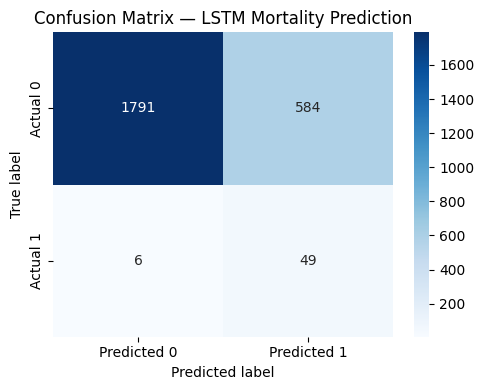

In [31]:
# Cell 21 - Visualize the confusion matrix as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix with annotations and labeled axes
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"]
)
plt.title("Confusion Matrix — LSTM Mortality Prediction")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


In [32]:
# Cell 21.5A — Define permutation importance for LSTM (classification)
# Define a function that shuffles one feature at a time and measures the resulting AUC drop
@torch.no_grad()
def permutation_importance_lstm(
    model, loader, feature_cols, baseline_auc, n_repeats=1
):
    model.eval()
    importances = []

# Loop over each feature and measure AUC drop when that feature is shuffled
    for j, feat in enumerate(feature_cols):
        drops = []

        for _ in range(n_repeats):
            all_probs, all_true = [], []

            for X_pad, y_pad, lengths, _ in loader:
                X_pad = X_pad.clone()
                y_pad = y_pad.to(device)

                # shuffle feature j
                vals = X_pad[:, :, j].cpu().numpy().flatten()
                np.random.shuffle(vals)
                X_pad[:, :, j] = torch.tensor(
                    vals.reshape(X_pad[:, :, j].shape),
                    dtype=X_pad.dtype
                )

                X_pad = X_pad.to(device)
                logits = model(X_pad, lengths)
                mask = (y_pad != -1)

                probs = torch.sigmoid(logits[mask]).cpu().numpy()
                true  = y_pad[mask].cpu().numpy()

                all_probs.append(probs)
                all_true.append(true)

            probs = np.concatenate(all_probs)
            true  = np.concatenate(all_true)

            auc = roc_auc_score(true, probs) if len(np.unique(true)) > 1 else np.nan
            drops.append(baseline_auc - auc)

        importances.append(np.nanmean(drops))

# Return ranked feature importances as mean AUC drop after shuffling each feature
    return pd.DataFrame({
        "feature": feature_cols,
        "importance_auc_drop": importances
    }).sort_values("importance_auc_drop", ascending=False)


In [33]:
# Cell 21.5B — Feature importance for mortality (Permutation Importance)
# Compute baseline AUC and estimate feature importance using permutation based AUC drop
baseline_auc = eval_loader(test_loader)["AUC"]

# Apply permutation importance to rank features by their impact on mortality prediction
feature_importance_mortality = permutation_importance_lstm(
    model=model,
    loader=test_loader,
    feature_cols=feature_cols,   # mortality feature set (LoS excluded)
    baseline_auc=baseline_auc,
    n_repeats=1
)

feature_importance_mortality.head(15)

,feature,importance_auc_drop
1,age,0.019621
9,admission_type_EW EMER.,0.013359
57,ccs_emb_23,0.009914
38,ccs_emb_4,0.008949
8,admission_type_EU OBSERVATION,0.006668
25,language_Chinese,0.005458
2,ER_LoS,0.004134
19,admission_location_Unknown/Other,0.004096
45,ccs_emb_11,0.003897
35,ccs_emb_1,0.003414


In [34]:
# Cell 22 — Define LoS regression target
LOS_COL = "LoS"

# Feature columns for LoS prediction (remove LoS itself)
los_feature_cols = [c for c in feature_cols if c != LOS_COL]

len(los_feature_cols)


65

In [35]:
# Cell 23 — Build LoS sequences (many-to-many regression)
# Construct per subject variable length input and target sequences for LoS regression
def build_los_sequences(df: pd.DataFrame):
    df = df.sort_values(["subject_id", ORDER_COL])

    X_list, y_list, lengths = [], [], []

    for _, g in df.groupby("subject_id", sort=False):
        X = torch.tensor(g[los_feature_cols].to_numpy(np.float32))   # (T, F)
        y = torch.tensor(g[LOS_COL].to_numpy(np.float32))            # (T,)
        X_list.append(X)
        y_list.append(y)
        lengths.append(len(g))

    return X_list, y_list, torch.tensor(lengths, dtype=torch.long)

# Build LoS input target sequences for training and test datasets
Xtr_los, ytr_los, Ltr_los = build_los_sequences(train)
Xte_los, yte_los, Lte_los = build_los_sequences(test)


In [36]:
# Cell 24 — DataLoaders for LoS regression
# Define dataset and collate function to handle variable-length LoS sequences
class LoSDataset(Dataset):
    def __init__(self, X_list, y_list, lengths):
        self.X = X_list
        self.y = y_list
        self.lengths = lengths

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.lengths[idx]

# Pad variable length input and target sequences for batching
def los_collate_fn(batch):
    Xs, ys, lens = zip(*batch)
    X_pad = pad_sequence(Xs, batch_first=True)
    y_pad = pad_sequence(ys, batch_first=True, padding_value=-1.0)
    lens  = torch.tensor(lens, dtype=torch.long)
    return X_pad, y_pad, lens

# Create DataLoaders for training and testing LoS regression models
train_los_loader = DataLoader(
    LoSDataset(Xtr_los, ytr_los, Ltr_los),
    batch_size=64, shuffle=True, collate_fn=los_collate_fn
)

test_los_loader = DataLoader(
    LoSDataset(Xte_los, yte_los, Lte_los),
    batch_size=64, shuffle=False, collate_fn=los_collate_fn
)


In [37]:
# Cell 25 — LSTM regression model
# Define an LSTM based many to many regression model for predicting LoS at each timestep
class LSTM_LoS(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

# Forward pass using packed sequences to handle variable-length inputs
    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        preds = self.fc(out).squeeze(-1)
        return preds


In [38]:
# Cell 26 — Loss & metrics (MSE / RMSE / MAE / R²)
# Initialize LoS regression model, loss function and evaluation metrics with masking
los_model = LSTM_LoS(input_dim=len(los_feature_cols)).to(device)
los_optimizer = torch.optim.Adam(los_model.parameters(), lr=1e-3)
los_criterion = nn.MSELoss()

# Define masked mean squared error to ignore padded timesteps
def masked_mse(pred, true):
    mask = (true != -1)
    return los_criterion(pred[mask], true[mask])

# Evaluate LoS model using MSE, RMSE, MAE, and R² on non-padded timesteps
@torch.no_grad()
def eval_los(loader):
    los_model.eval()
    all_preds, all_true = [], []

    for X_pad, y_pad, lengths in loader:
        X_pad = X_pad.to(device)
        y_pad = y_pad.to(device)

        preds = los_model(X_pad, lengths)
        mask = (y_pad != -1)

        all_preds.append(preds[mask].cpu().numpy())
        all_true.append(y_pad[mask].cpu().numpy())

# Aggregate predictions and compute regression metrics
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    mse  = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(y_pred - y_true))
    r2   = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

    return mse, rmse, mae, r2


In [39]:
# Cell 27 — Train LoS regression model
# Train the LoS LSTM using masked MSE loss with early stopping based on test RMSE
EPOCHS = 20
best_rmse = np.inf
patience = 5
bad = 0

# Training loop with validation based early stopping
for epoch in range(1, EPOCHS + 1):
    los_model.train()
    total_loss = 0.0

    for X_pad, y_pad, lengths in train_los_loader:
        X_pad = X_pad.to(device)
        y_pad = y_pad.to(device)

        los_optimizer.zero_grad()
        preds = los_model(X_pad, lengths)
        loss = masked_mse(preds, y_pad)
        loss.backward()
        los_optimizer.step()

        total_loss += loss.item()

# Evaluate model performance on the test set after each epoch
    mse, rmse, mae, r2 = eval_los(test_los_loader)

    print(f"Epoch {epoch:02d} | TrainLoss={total_loss:.3f} | MSE={mse:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f} | R2={r2:.3f}")

    if rmse < best_rmse:
        best_rmse = rmse
        bad = 0
        torch.save(los_model.state_dict(), "best_lstm_los.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break


Epoch 01 | TrainLoss=4724.842 | MSE=61.063 | RMSE=7.814 | MAE=3.896 | R2=-0.164
Epoch 02 | TrainLoss=3876.712 | MSE=54.040 | RMSE=7.351 | MAE=3.671 | R2=-0.030
Epoch 03 | TrainLoss=3743.927 | MSE=49.871 | RMSE=7.062 | MAE=3.621 | R2=0.050
Epoch 04 | TrainLoss=3373.178 | MSE=46.798 | RMSE=6.841 | MAE=3.435 | R2=0.108
Epoch 05 | TrainLoss=3227.264 | MSE=45.155 | RMSE=6.720 | MAE=3.307 | R2=0.140
Epoch 06 | TrainLoss=3096.757 | MSE=44.132 | RMSE=6.643 | MAE=3.317 | R2=0.159
Epoch 07 | TrainLoss=2989.528 | MSE=43.649 | RMSE=6.607 | MAE=3.253 | R2=0.168
Epoch 08 | TrainLoss=2992.253 | MSE=43.503 | RMSE=6.596 | MAE=3.260 | R2=0.171
Epoch 09 | TrainLoss=2883.582 | MSE=43.071 | RMSE=6.563 | MAE=3.242 | R2=0.179
Epoch 10 | TrainLoss=2828.117 | MSE=42.822 | RMSE=6.544 | MAE=3.231 | R2=0.184
Epoch 11 | TrainLoss=2835.104 | MSE=42.923 | RMSE=6.552 | MAE=3.253 | R2=0.182
Epoch 12 | TrainLoss=2745.737 | MSE=42.879 | RMSE=6.548 | MAE=3.314 | R2=0.183
Epoch 13 | TrainLoss=2749.469 | MSE=42.938 | RMSE=

In [40]:
# Cell 28 — Final LoS test performance
# Load the best LoS model and report final regression metrics on the test set
los_model.load_state_dict(torch.load("best_lstm_los.pt", map_location=device))
final_mse, final_rmse, final_mae, final_r2 = eval_los(test_los_loader)

final_mse, final_rmse, final_mae, final_r2


/tmp/ipykernel_85/3093555071.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  los_model.load_state_dict(torch.load("best_lstm_los.pt", map_location=device))


(42.822174, 6.543865, 3.230691, 0.1840606927871704)

In [41]:
# Cell 28.5 - Describe the distribution of Length of Stay values
train["LoS"].describe()

count    9388.000000
mean        4.919814
std         7.635377
min        -0.867361
25%         1.135417
50%         2.838194
75%         5.724653
max       207.152778
Name: LoS, dtype: float64

In [42]:
# Cell 29 — Feature importance for LoS (Permutation Importance)
# Define permutation based feature importance for LoS regression using RMSE increase
@torch.no_grad()
def permutation_importance_lstm_regression(
    model, loader, feature_cols, baseline_rmse
):
    model.eval()
    importances = []

# Define permutation-based feature importance for LoS regression using RMSE increase
    for j, feat in enumerate(feature_cols):
        all_preds, all_true = [], []

        for X_pad, y_pad, lengths in loader:
            X_pad = X_pad.clone()
            y_pad = y_pad.to(device)

            vals = X_pad[:, :, j].cpu().numpy().flatten()
            np.random.shuffle(vals)
            X_pad[:, :, j] = torch.tensor(
                vals.reshape(X_pad[:, :, j].shape),
                dtype=X_pad.dtype
            )

            X_pad = X_pad.to(device)
            preds = model(X_pad, lengths)

            mask = (y_pad != -1)
            all_preds.append(preds[mask].cpu().numpy())
            all_true.append(y_pad[mask].cpu().numpy())

        y_pred = np.concatenate(all_preds)
        y_true = np.concatenate(all_true)

        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        importances.append(rmse - baseline_rmse)

# Return ranked feature importances as RMSE increase after shuffling each feature
    return pd.DataFrame({
        "feature": feature_cols,
        "importance_rmse_increase": importances
    }).sort_values("importance_rmse_increase", ascending=False)


In [43]:
# Cell 30 - Feature importance for leangth of stay (Permutation Importance)
# Compute baseline RMSE and estimate feature importance for LoS using permutation based RMSE increase
_, baseline_rmse, _, _ = eval_los(test_los_loader)

# Apply permutation importance to rank LoS features by increase in RMSE
feature_importance_los = permutation_importance_lstm_regression(
    model=los_model,
    loader=test_los_loader,
    feature_cols=los_feature_cols,
    baseline_rmse=baseline_rmse
)

feature_importance_los.head(15)


,feature,importance_rmse_increase
8,admission_type_EU OBSERVATION,0.143984
6,admission_type_DIRECT OBSERVATION,0.054935
9,admission_type_EW EMER.,0.048702
10,admission_type_OBSERVATION ADMIT,0.044526
17,admission_location_TRANSFER FROM HOSPITAL,0.042712
14,admission_location_EMERGENCY ROOM,0.042135
49,ccs_emb_15,0.038873
12,admission_type_URGENT,0.029407
5,admission_type_DIRECT EMER.,0.025131
7,admission_type_ELECTIVE,0.024276
